# Chunks

Author: Pavel Agurov, pavel_agurov@epam.com

Even with the very large context window of modern models (1-2M tokens), sending the entire document to the model is expensive and time consuming. And it's not always efficient - model works good for first and last parts of text and can lost focus on the middle (see articles https://blog.langchain.dev/multi-needle-in-a-haystack/ and https://docs.google.com/presentation/d/1mJUiPBdtf58NfuSEQ7pVSEQ2Oqmek7F1i4gBwR6JDss/edit#slide=id.g26c0cb8dc66_0_92).

The idea is to somehow split the text into chunks (we'll call it a "chunk") and use embedding-based similarity search to find only the relevant chunks and send them to the model.

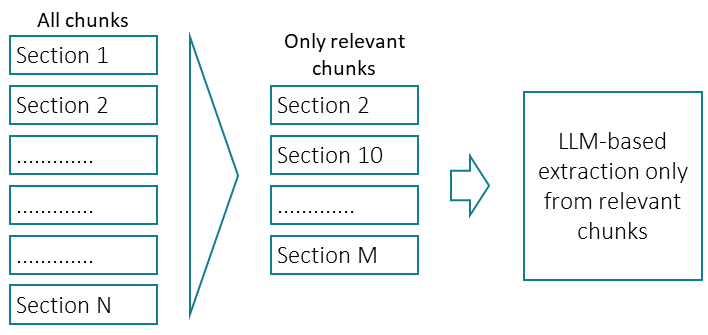


Chunk strategy is very complex problem and there is no one global solution for all cases.

Let's see some examples and ideas.


## Preparation

In [ ]:
%pip install openai > /dev/null
%pip install tiktoken > /dev/null
%pip install langchain > /dev/null
%pip install langchain_openai > /dev/null
%pip install langchain_core > /dev/null
%pip install langchain_community > /dev/null
%pip install langchain_text_splitters > /dev/null
%pip install sentence-transformers > /dev/null
%pip install beautifulsoup4 > /dev/null

In [56]:
import os
from langchain_openai.embeddings.azure import AzureOpenAIEmbeddings

# your GPT key should be in OPENAI_API_KEY environment variable
openai_ada_embeddings = AzureOpenAIEmbeddings(
    model          ="text-embedding-ada-002",
    api_key        = os.environ['OPENAI_API_KEY'],
    azure_endpoint = "https://ai-proxy.lab.epam.com",
)

In [57]:
from langchain_community.embeddings import SentenceTransformerEmbeddings

sbert_embeddings = SentenceTransformerEmbeddings(
    model_name= 'sentence-transformers/all-MiniLM-L6-v2',
    model_kwargs={"device": "cpu"}
)

In [58]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine_sentences(emd, s1, s2):
    v1 = emd.embed_documents([s1])[0]
    v2 = emd.embed_documents([s2])[0]
    return cosine_similarity([v1], [v2])[0][0]

In [11]:
import os
import textwrap
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import AzureChatOpenAI

epam_dial = AzureChatOpenAI(
        api_key         = os.environ['OPENAI_API_KEY'],
        api_version     = "2023-07-01-preview",
        azure_endpoint  = "https://ai-proxy.lab.epam.com",
        model           = "gpt-4o-mini-2024-07-18",
        temperature     = 0.0
    )

## Optimal chunk size: similarity of small chunks

The first question is to find the optimal size of chunk. A chunk can't be too big - we will have not good similarity, but chunk can't be too small - we can lost critical details when we will use chunks. Let's check it on simple example.

In [45]:
# text copied from https://www.inclusion-europe.eu/helena-dalli-unfortunately-many-people-still-think-that-institutions-are-safe-places-this-is-simply-not-true/

text = """
“'Institutional care' is a contradiction in terms. No institutional care is better than community-based care, 
family care, or personal care.” This is what European Commissioner for Equality Helena Dalli said yesterday at the “Towards inclusion” conference, 
organised by the European Expert Group on the Transition from Institutional to Community-based Care (EEG) and attended by more than 200 invited participants. 
She added that “unfortunately, many people still think institutions are safe places. They believe that they protect children or people with disabilities, 
especially people with intellectual disabilities, from the outside world. But this is simply not true. People have a right to, and enjoy, living independently 
and in a community - it is where they truly flourish.”
"""

print(len(text))

789


Let's check similarity between full text, part of the text and sentences from this text. Of course, this text is not very long, but we only want to show the basic idea - similarity of sentence can be better than full text.

In [60]:
def print_similarity_test(embedding):
    print(f"Similarity test {embedding.__class__.__name__}")
    topic = "children protection"

    s = cosine_sentences(embedding, text, topic)
    print(f"Similarity between part of the text and topic: {s:.2f}")

    sentences = text.split(".")
    for i, sentence in enumerate(sentences):
        s = cosine_sentences(embedding, sentence, topic)
        print(f"Similarity between sentence {i} and topic: {s:.2f}")
        
print_similarity_test(openai_ada_embeddings)

Similarity test AzureOpenAIEmbeddings
Similarity between part of the text and topic: 0.81
Similarity between sentence 0 and topic: 0.79
Similarity between sentence 1 and topic: 0.76
Similarity between sentence 2 and topic: 0.78
Similarity between sentence 3 and topic: 0.77
Similarity between sentence 4 and topic: 0.84
Similarity between sentence 5 and topic: 0.71
Similarity between sentence 6 and topic: 0.76
Similarity between sentence 7 and topic: 0.78


And the same for SBERT embedding:

In [61]:
print_similarity_test(sbert_embeddings)

Similarity test HuggingFaceEmbeddings
Similarity between part of the text and topic: 0.24
Similarity between sentence 0 and topic: 0.09
Similarity between sentence 1 and topic: 0.16
Similarity between sentence 2 and topic: 0.16
Similarity between sentence 3 and topic: 0.21
Similarity between sentence 4 and topic: 0.48
Similarity between sentence 5 and topic: 0.01
Similarity between sentence 6 and topic: 0.14
Similarity between sentence 7 and topic: 0.15


The best match is sentense 4.

In [62]:
sentence4 = text.split(".")[4]
print(sentence4)

 They believe that they protect children or people with disabilities, 
especially people with intellectual disabilities, from the outside world


As result, we can say that optimal chunk size depends on embedding, but short text has better similarity. Also you can see that OpenAI embedding works much better for long text than SBET. It's expected, because openAI has longer vector.

## How to split text

There are many strategies for breaking up text into chunks. Unfortunately, there is no single best strategy.

We can split text based on different strategies, but all of them have pros and cosn.
- Fixed size chunking: 
    - simple split by count of chars
    - simple split by count of tokens
- Sentence-Based chunking:
    - split by sentenses
    - split by paragraphs
    - Recursive character splitter (split more than one separator)
- Content-based chucking:
    - split by special tags (HTML tags, LaTeX, markdown)
    - based on programming language syntax
- Semantic-based chunking (like RAPTOR)

Looks like simple? In fact - not so easy. For example, we can divide text into sentences using delimiters .!?.  But in German the dot is part of the date or can be a date separator: "20. Juni" or "20.06.2024". It means we can't just split by the dot char, we should apply additional rules and use NLP.

Semantic chunker dynamically creates the breakpoint between paragraphs or sentences based on embedding similarity. This ensures that each "chunk" contains semantically cohesive sentences. It works good for fictions, but doesn't work for "uniform" text like financial statements.

On top of the text division, we can add an overlap of chunks - the chunks will have a common part. This allows us to maintain the connection between chunks.

In [66]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

# we will split text by paragraphs
text_splitter_by_paragpaph = RecursiveCharacterTextSplitter(
    chunk_size      = 100,
    chunk_overlap   = 0,
    separators      = ["\n\n"],
    keep_separator  = True,
    length_function = len,
    is_separator_regex=False,
    add_start_index = True
)

chunks = text_splitter_by_paragpaph.split_documents([Document(text)])
print(len(chunks))


1


In [67]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

# we will split text by sentences
text_splitter_by_sentences = RecursiveCharacterTextSplitter(
    chunk_size      = 100,
    chunk_overlap   = 0,
    separators      = [".", "!", "?", "\n\n"],
    keep_separator  = True,
    length_function = len,
    is_separator_regex=False,
    add_start_index = True
)

chunks = text_splitter_by_sentences.split_documents([Document(text)])
print(len(chunks))

8


There are many splitters (https://api.python.langchain.com/en/latest/text_splitters_api_reference.html#). It can be splitter for concrete format (for example `MarkdownTextSplitter`) or with usage of extenal frameworks (ex. `SpacyTextSplitter`). You should find the best splitter depends on your data and expected performance. 

### Optimal chunk size: possible loss of information

Let's check one more situation. For example, we want to create summary from relevant chunks and split the text into chunks not in the best way. We will build summary for full text and for part of it.

In [49]:
# create prompt from template with parameters
prompt = ChatPromptTemplate.from_template("Create a summary as one sentense from provided text: {text}")

# create chain
chain = prompt | epam_dial | StrOutputParser()

# now we will provide parameters as dict
summary_text = chain.invoke({"text" : text})

# print result
print(f'{textwrap.fill(summary_text, 80)}\n')

European Commissioner for Equality Helena Dalli stated that institutional care
is a contradiction and community-based care is preferable, as institutions do
not provide true safety or independence for individuals with disabilities.



Let's look at the words "But this is simply not true" at the end of the text and imagine that we only got part of the text for a summary.

In [55]:
print(">>> Text:")
print(text[:630])

# now we will provide parameters as dict
summary_text = chain.invoke({"text" : text[:630]})

# print result
print(">>> Summary:")
print(f'{textwrap.fill(summary_text, 80)}\n')

>>> Text:

“'Institutional care' is a contradiction in terms. No institutional care is better than community-based care, 
family care, or personal care.” This is what European Commissioner for Equality Helena Dalli said yesterday at the “Towards inclusion” conference, 
organised by the European Expert Group on the Transition from Institutional to Community-based Care (EEG) and attended by more than 200 invited participants. 
She added that “unfortunately, many people still think institutions are safe places. They believe that they protect children or people with disabilities, 
especially people with intellectual disabilities, from t
>>> Summary:
harm, but in reality, community-based care is more effective and beneficial for
individuals."



The result is completely opposite! So, we can say that we should break the text into parts, at least into paragraphs.

# Hierarchical chunks

We can use hierarchical chunking - use small chunks for similarity search, but big chunks for extraction. In this case we can solve issues with similarity and completeness of information. 


LlamaIndex framework has this functionality out of the box, but in general it's very easy to implemen in any framework.


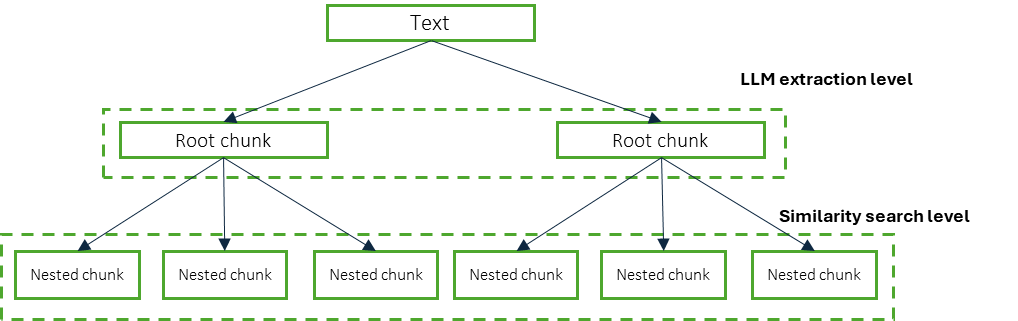

# Issue 1: headers

This situation usually happens with website pages - a block of text contains very short and specific information and does not repeat the information from the title.

- Header 1: Passport
    - [information about passort]
    - Header 2: Cost
        - here is information about cost
- Header 1: Visa
    - [information about visa]
    - Header 2: Cost
        - here is information about cost

We split this text by headers and have 2 chunks. Both of them are about cost. First one is about cost of passport, second one is about cost of visa, but both of them can be found by similarity search and both of them have header "cost". Without information from header level 1 we can't restore context. But in simple scenario we have header 1 in another chunk.

Solution is to store full header line into each chunk:

- Chunk01. Header 1: Passport
    - [information about passort]
- Chunk02. Header 1: Passport >> Header 2: Cost
    - here is information about cost
- Chunk03. Header 1: Visa
    - [information about visa]
- Chunk04. Header 1: Visa >> Header 2: Cost
    - here is information about cost

Here we have 4 chunks, but each chunk has full relevant information about context.

In [73]:
from langchain_text_splitters import MarkdownHeaderTextSplitter

md_text = """
# header 1.1
  body text 1.1
  ## header 1.2
    body text 1.2
# header 2.1
  body text 2.1
  ## header 2.2
    body text 2.2
"""

headers_to_split_on = [
    ("#"   , "Header_1"),
    ("##"  , "Header_2")
]


markdown_splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on = headers_to_split_on,
    strip_headers       = True # we will add headers manually
)

chunks = markdown_splitter.split_text(md_text)
for ch in chunks:
    print(ch)

page_content='body text 1.1' metadata={'Header_1': 'header 1.1'}
page_content='body text 1.2' metadata={'Header_1': 'header 1.1', 'Header_2': 'header 1.2'}
page_content='body text 2.1' metadata={'Header_1': 'header 2.1'}
page_content='body text 2.2' metadata={'Header_1': 'header 2.1', 'Header_2': 'header 2.2'}


Now we can easy combine all headers into full header based on metadata.

In [74]:
_HEADER_SEPARATOR = " > "

def build_md_header_line_by_metadata(metadata : dict[str, str]) -> str:
    """
        Build one header line from the document metadata
    """
    header_line_array = []
    for i in range(1, 10): # no makes sense more than 10 headers
        header_level_str = f"Header_{i}"
        if header_level_str not in metadata:
            break
        header_line = metadata[header_level_str].strip()
        header_line_array.append(header_line)
    header_line_str = _HEADER_SEPARATOR.join(header_line_array)
    header_md_prefix = "#" * len(header_line_array)
    return f"{header_md_prefix} {header_line_str}"

for ch in chunks:
    print(build_md_header_line_by_metadata(ch.metadata))


# header 1.1
## header 1.1 > header 1.2
# header 2.1
## header 2.1 > header 2.2


# Issue 2: pronouns and references

But even split by paragraphs does not always solve all problems with chunks. As another example, let's take a text that has two paragraphs. The first one talks about Elon Musk, and the second one uses a pronoun. If we divide the text into paragraph chunks and use the second chunk, then we will have no way to understand who the text is about.

# Conclusion

Chunking is a very complex problem. The solution depends on the structure and type of texts - fiction, financial statements, contracts.

There are another solutions - semantic chunking (like RAPTOR), fact extraction, knowledge graph etc., but it's out of this notebook.

Additional complexity comes from tables and table headers. The table can be very long and even places on more than one page. It's also required additional processing (in ideal case - extraction from text into data table).